In [135]:
import sys
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from IPython.core.display import display, HTML
import json
from zipfile import ZipFile

import warnings
warnings.filterwarnings('ignore')

In [61]:
file_name_chl = 'chl_nn.nc'

In [62]:
OLCI_file = xr.open_dataset(os.path.join(file_name_chl))

In [63]:
OLCI_file

<xarray.Dataset>
Dimensions:     (columns: 4865, rows: 4091)
Dimensions without coordinates: columns, rows
Data variables:
    CHL_NN      (rows, columns) float32 ...
    CHL_NN_err  (rows, columns) float32 ...
Attributes: (12/16)
    absolute_orbit_number:  22724
    ac_subsampling_factor:  64
    al_subsampling_factor:  1
    comment:                 
    contact:                ops@eumetsat.int
    creation_time:          2020-06-29T18:11:38Z
    ...                     ...
    references:             S3IPF PDS 004.3 - i2r2 - Product Data Format Spec...
    resolution:             [ 270 294 ]
    source:                 IPF-OL-2 06.13
    start_time:             2020-06-28T09:28:15.649581Z
    stop_time:              2020-06-28T09:31:15.614557Z
    title:                  OLCI Level 2 WATER Product, Neutral Net Chlorophy...

In [64]:
CHL     = OLCI_file.CHL_NN.data
OLCI_file.close()

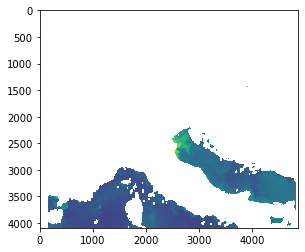

In [65]:
plt.imshow(CHL);

In [94]:
row1=200
row2=7000
col1=2450
col2=5000
grid_factor=2
CHL_subset = CHL[row1:row2:grid_factor, col1:col2:grid_factor]

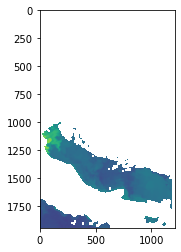

In [95]:
plt.imshow(CHL_subset);

In [96]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

land_resolution = '50m'
land_poly = cfeature.NaturalEarthFeature('physical', 'land', land_resolution,
                                        edgecolor='k',
                                        facecolor=cfeature.COLORS['land'])

In [128]:
file_name_geo = 'geo_coordinates.nc'
GEO_file      = xr.open_dataset(os.path.join(file_name_geo))
LAT           = GEO_file.variables['latitude'][:]
LON           = GEO_file.variables['longitude'][:]
LAT_subset    = LAT[row1:row2:grid_factor, col1:col2:grid_factor]
LON_subset    = LON[row1:row2:grid_factor, col1:col2:grid_factor]
GEO_file.close()

In [129]:
GEO_file

<xarray.Dataset>
Dimensions:    (columns: 4865, rows: 4091)
Dimensions without coordinates: columns, rows
Data variables:
    altitude   (rows, columns) int16 ...
    latitude   (rows, columns) float64 ...
    longitude  (rows, columns) float64 ...
Attributes: (12/16)
    absolute_orbit_number:  22724
    ac_subsampling_factor:  64
    al_subsampling_factor:  1
    comment:                 
    contact:                ops@eumetsat.int
    creation_time:          2020-06-29T18:11:38Z
    ...                     ...
    references:             S3IPF PDS 004.3 - i2r2 - Product Data Format Spec...
    resolution:             [ 270 294 ]
    source:                 IPF-OL-2 06.13
    start_time:             2020-06-28T09:28:15.649581Z
    stop_time:              2020-06-28T09:31:15.614557Z
    title:                  OLCI Level 2 WATER Product, Geo Coordinates Data Set

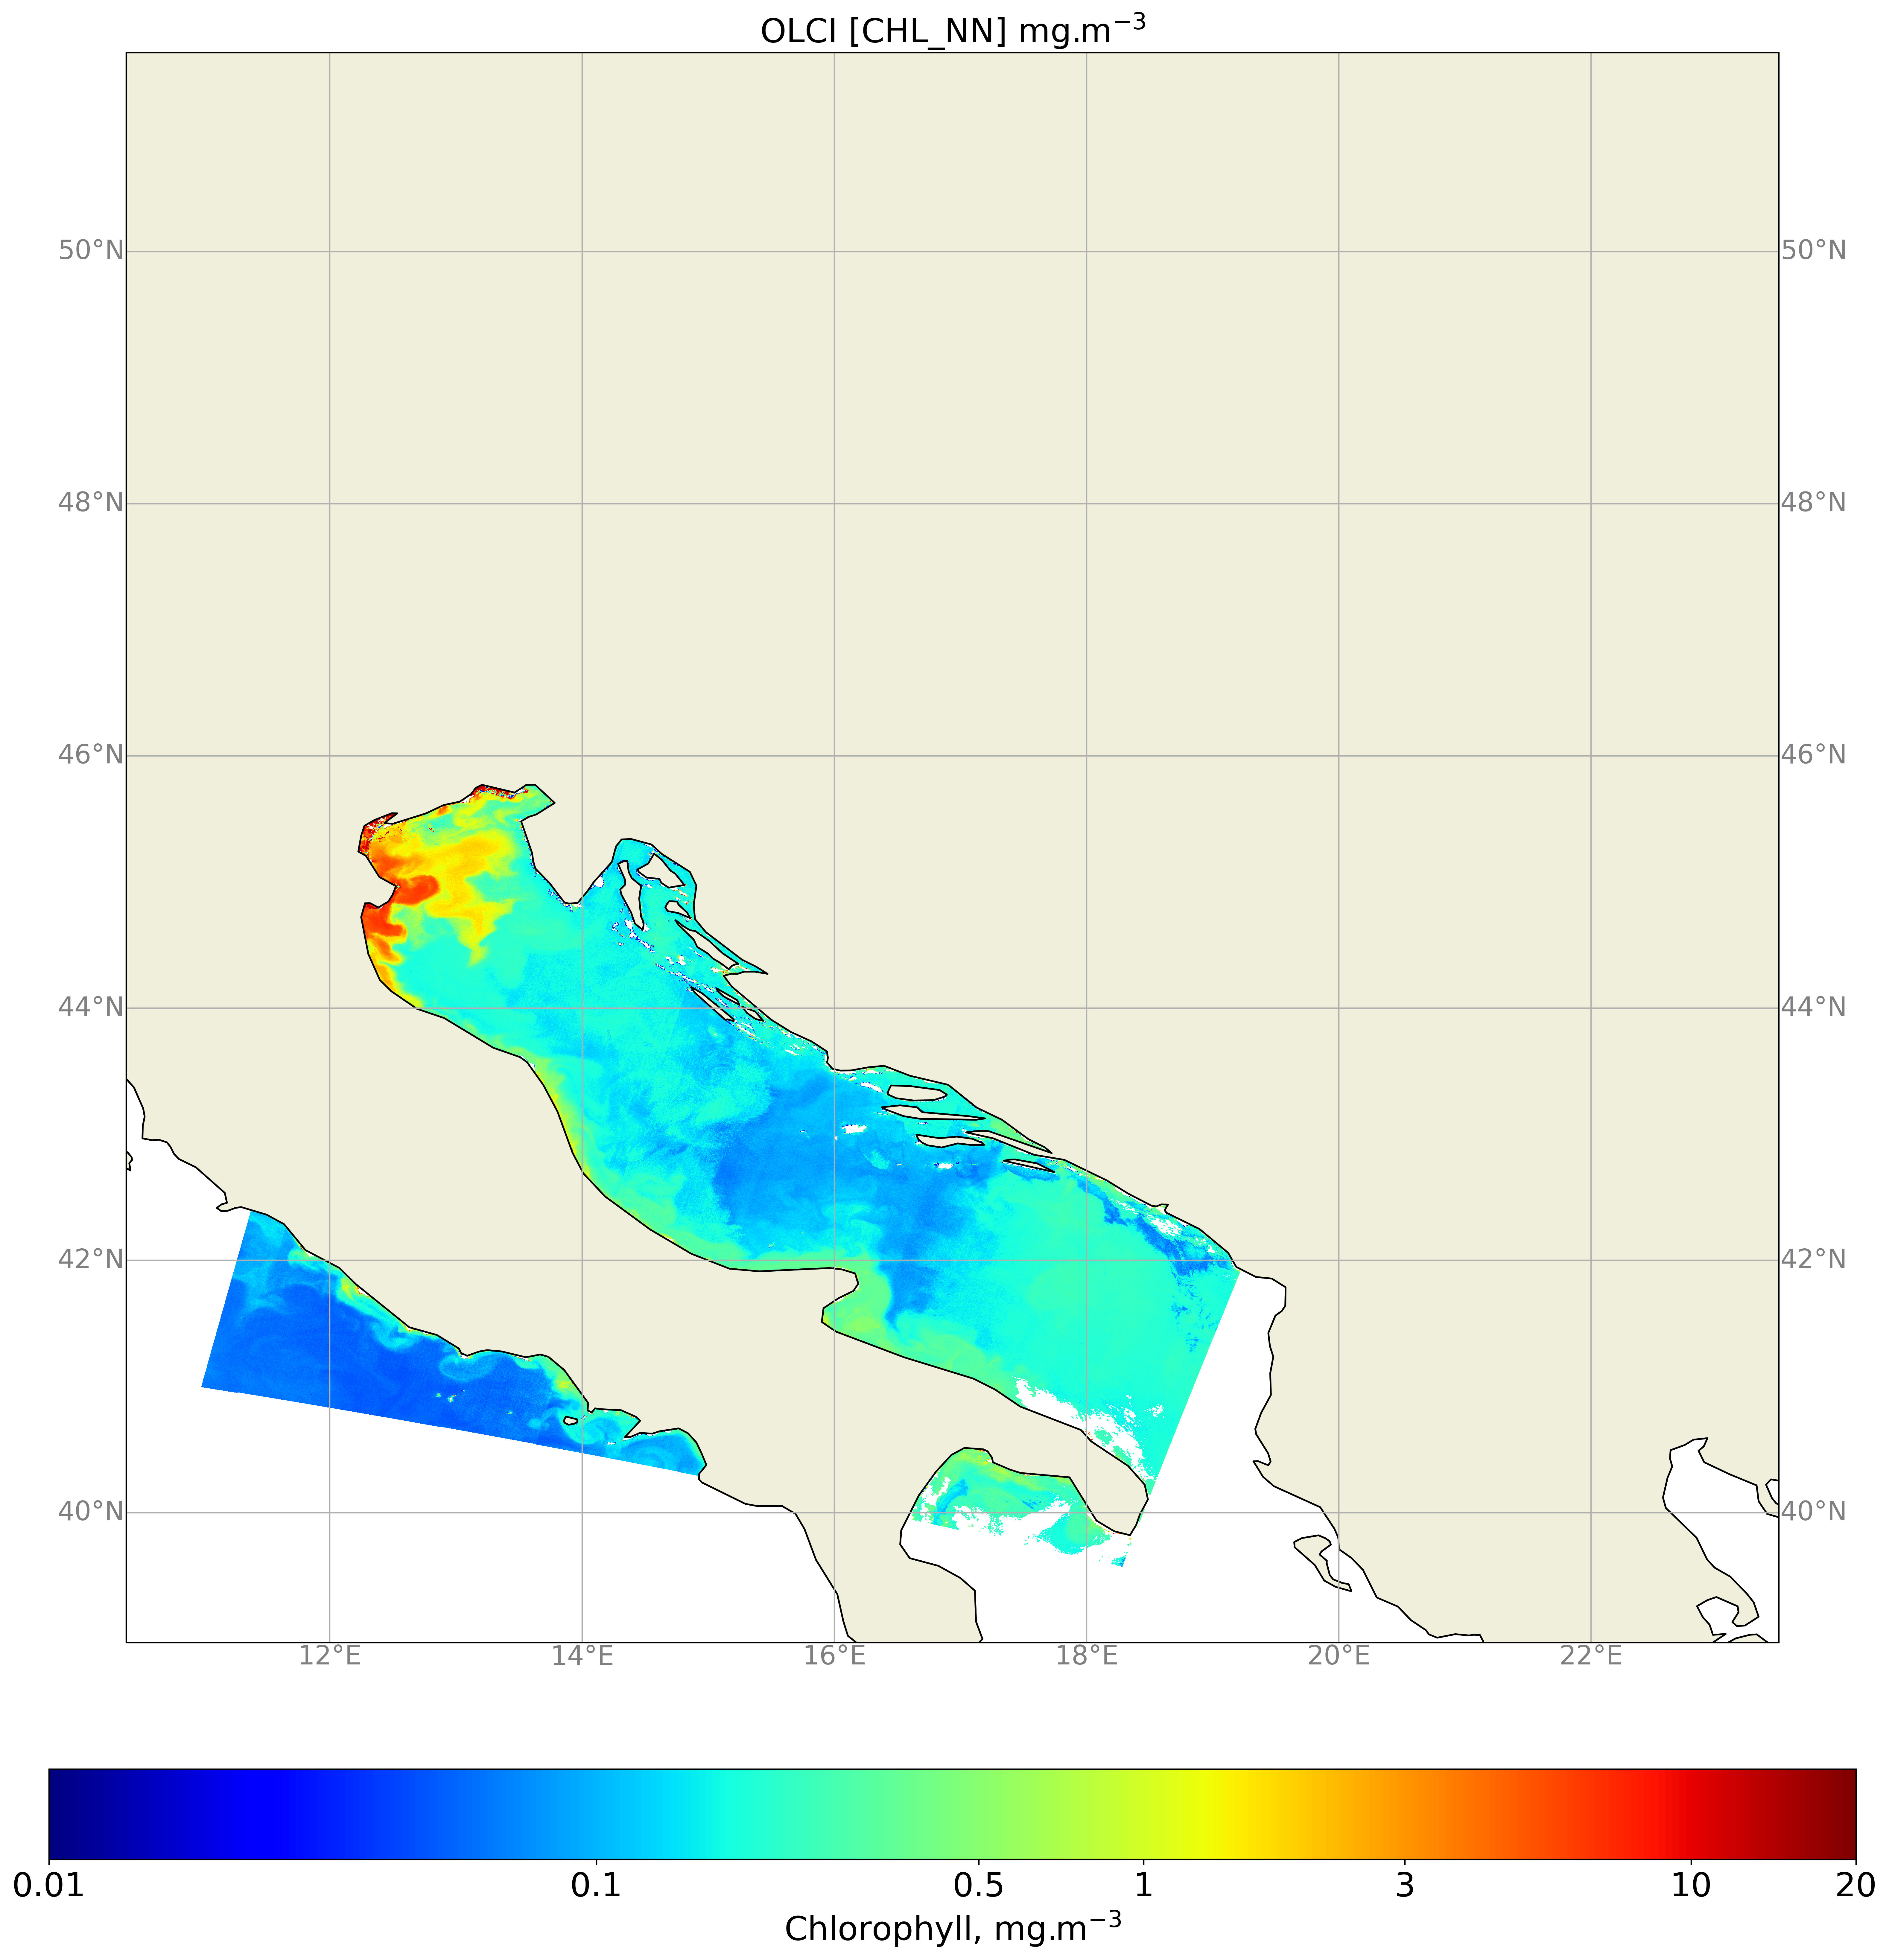

In [130]:
fig2 = plt.figure(figsize=(20, 20), dpi=400)
m = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.0))
f1 = plt.pcolormesh(LON_subset,LAT_subset,np.ma.masked_invalid(CHL_subset), shading='flat', vmin=np.log10(0.01), vmax=np.log10(20), cmap=plt.cm.jet)  
m.coastlines(resolution=land_resolution, color='black', linewidth=1)
m.add_feature(land_poly)
g1 = m.gridlines(draw_labels = True)
g1.xlabels_top = False
g1.xlabel_style = {'size': 16, 'color': 'gray'}
g1.ylabel_style = {'size': 16, 'color': 'gray'}
cbar = plt.colorbar(f1, orientation="horizontal", fraction=0.05, pad=0.07, ticks=[np.log10(0.01), np.log10(0.1),np.log10(0.5), np.log10(1),np.log10(3),np.log10(10),np.log10(20)]) 
cbar.ax.set_xticklabels(['0.01','0.1','0.5','1','3','10','20'], fontsize=20) 
cbar.set_label('Chlorophyll, mg.m$^{-3}$', fontsize=20)
plt.title('OLCI [CHL_NN] mg.m$^{-3}$', fontsize=20);
plt.show()

In [131]:
def flag_data_fast(flags_we_want, flag_names, flag_values, flag_data, flag_type='WQSF'):
    flag_bits = np.uint64()
    if flag_type == 'SST':
        flag_bits = np.uint8()
    elif flag_type == 'WQSF_lsb':
        flag_bits = np.uint32()
    
    for flag in flags_we_want:
        try:
            flag_bits = flag_bits | flag_values[flag_names.index(flag)]
        except:
            print(flag + " not present")
    
    return (flag_data & flag_bits) > 0

In [132]:
flags_we_want = ['CLOUD', 'CLOUD_AMBIGUOUS', 'CLOUD_MARGIN', 'INVALID', 'COSMETIC', 'SATURATED', 'SUSPECT',
                 'HISOLZEN', 'HIGHGLINT', 'SNOW_ICE', 'AC_FAIL', 'WHITECAPS', 'ANNOT_ABSO_D', 'ANNOT_MIXR1',
                 'ANNOT_TAU06']

file_name_flags = 'wqsf.nc'
FLAG_file = xr.open_dataset(os.path.join(file_name_flags))
# get all the flag names
flag_names = FLAG_file['WQSF'].flag_meanings.split(' ')
# get all the flag bit values
flag_vals = FLAG_file['WQSF'].flag_masks
# get the flag field itself
FLAGS = FLAG_file.variables['WQSF'].data
FLAG_file.close()

# make the flag mask using the function we defined above "flag_data_fast"
flag_mask = flag_data_fast(flags_we_want, flag_names, flag_vals, FLAGS, flag_type='WQSF')
flag_mask = flag_mask.astype(float)
flag_mask[flag_mask == 0.0] = np.nan

# subset the flag mask
FLAG_subset = flag_mask[row1:row2:grid_factor, col1:col2:grid_factor]

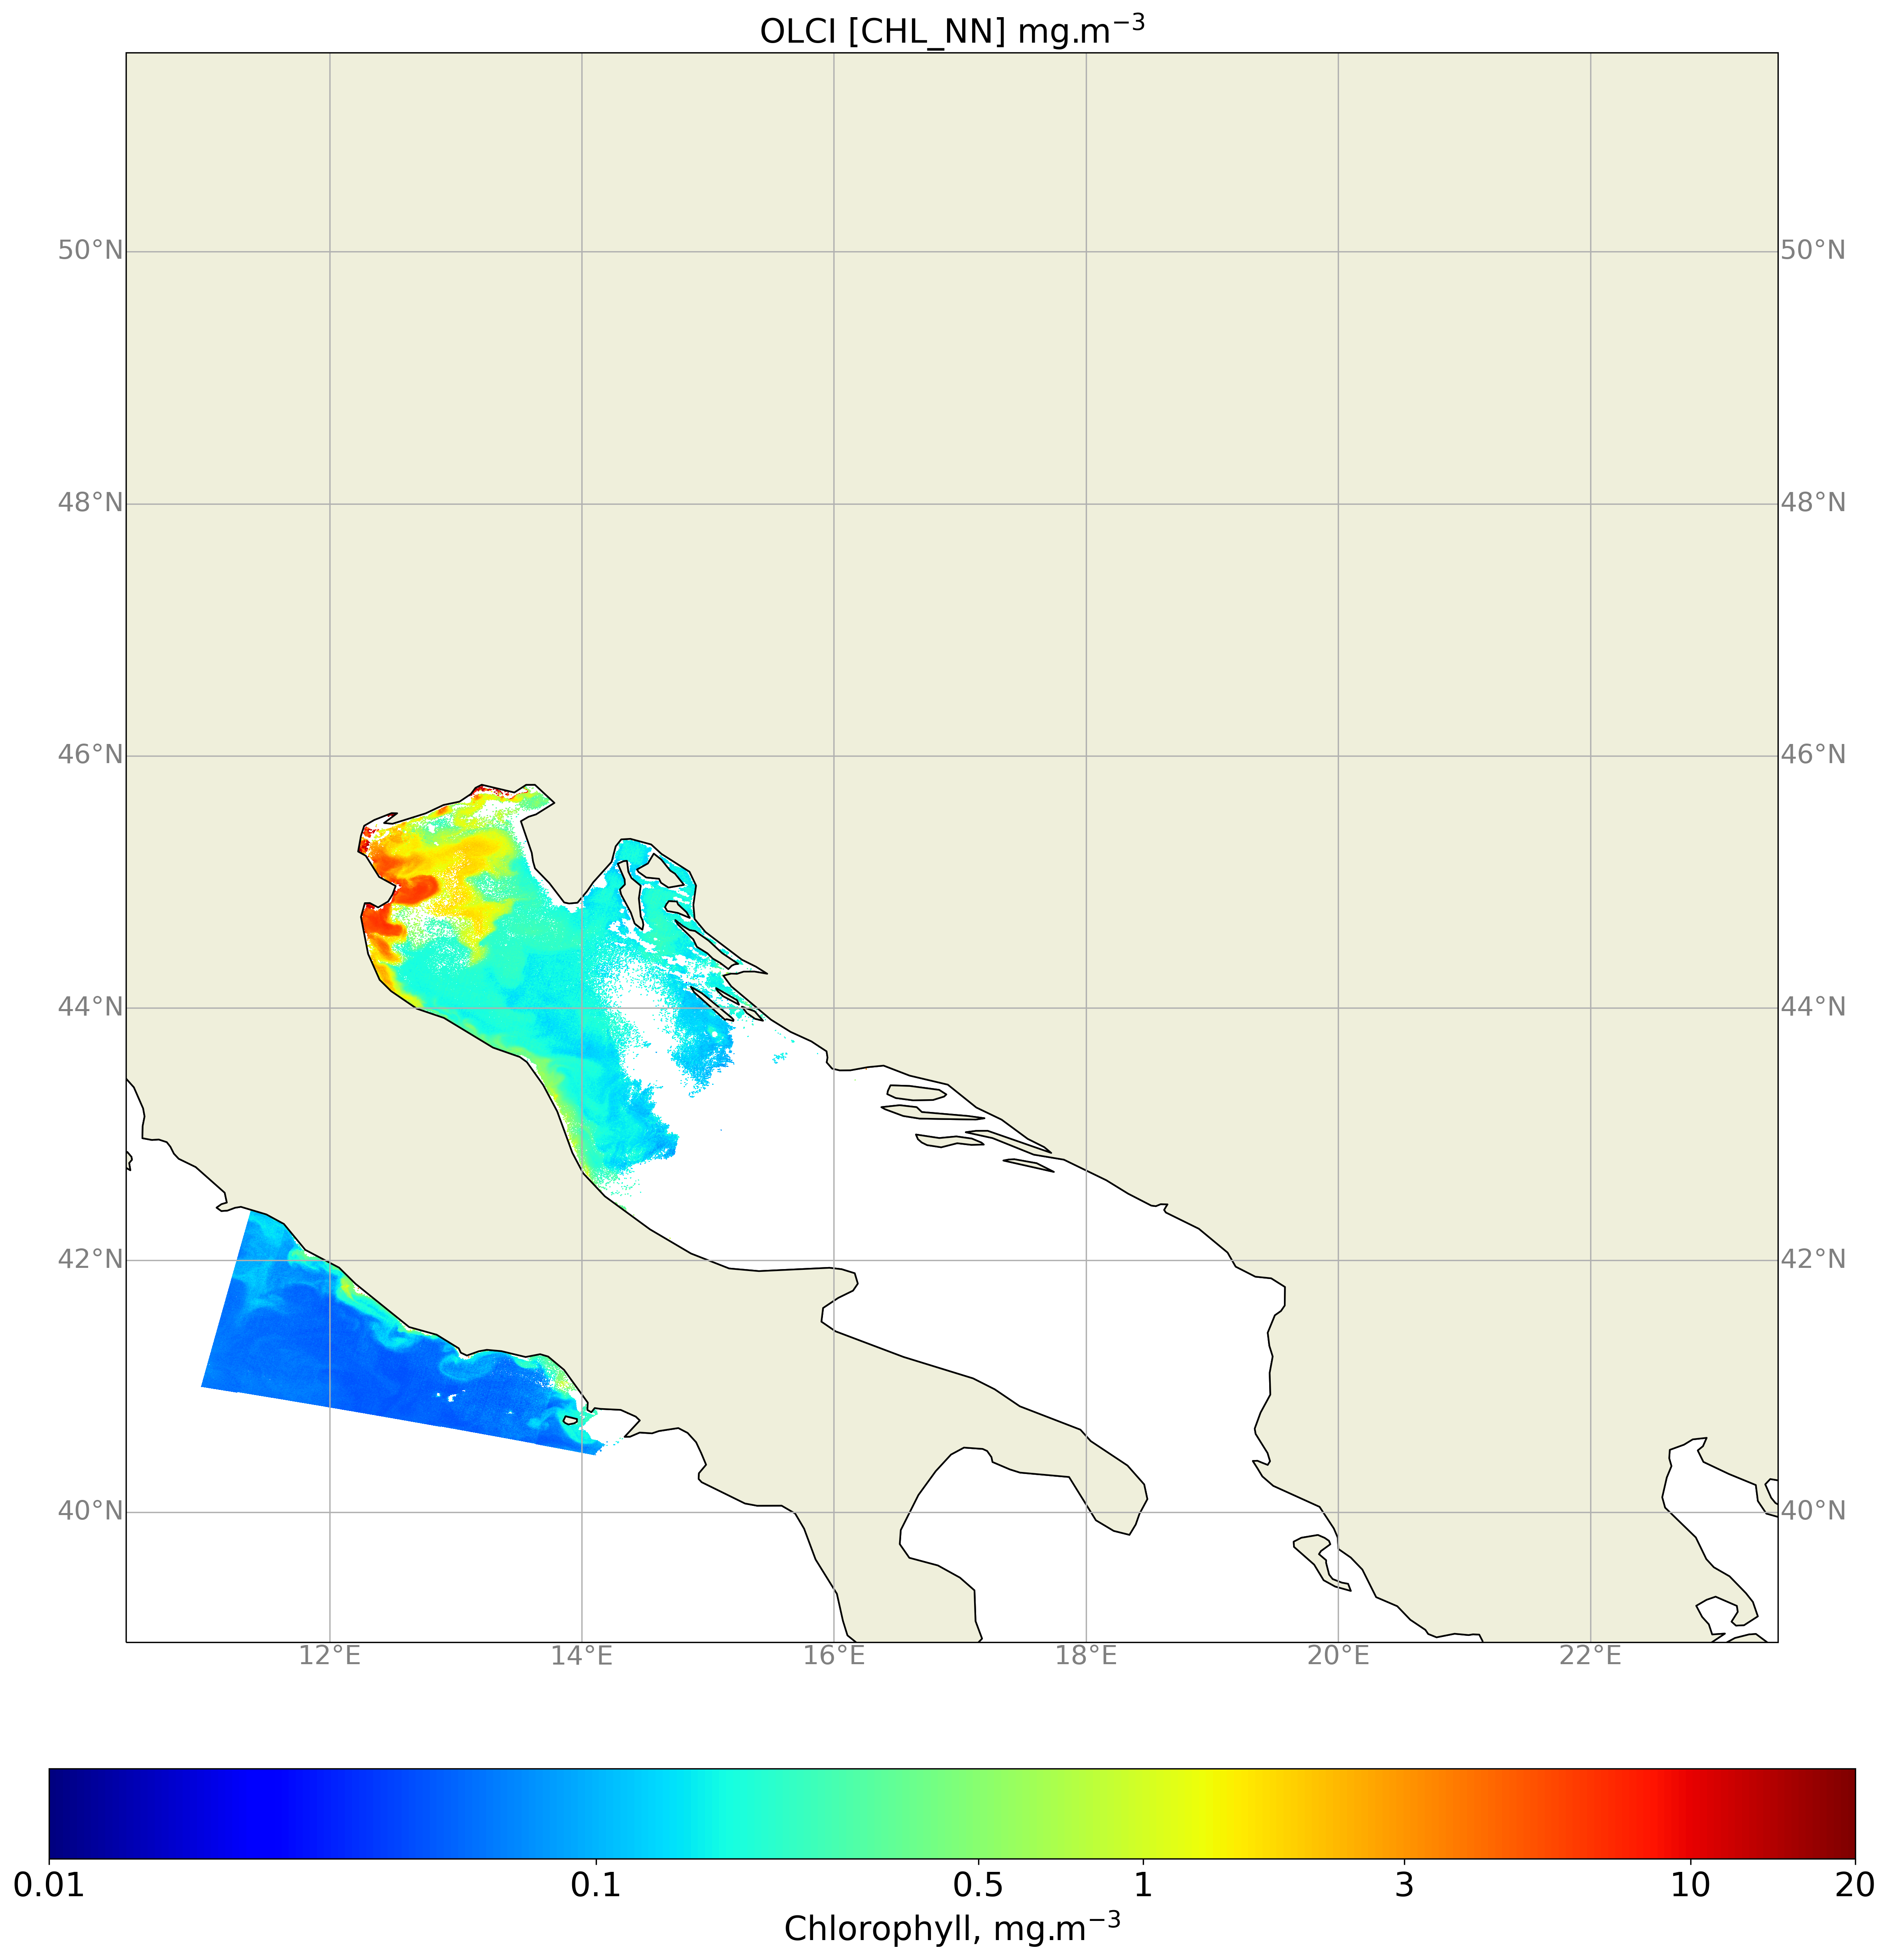

In [134]:
CHL_subset[np.isfinite(FLAG_subset)] = np.nan

fig3 = plt.figure(figsize=(20, 20), dpi=300)
m = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.0))
f1 = plt.pcolormesh(LON_subset,LAT_subset,np.ma.masked_invalid(CHL_subset), shading='flat', vmin=np.log10(0.01), vmax=np.log10(20), cmap=plt.cm.jet)  
m.coastlines(resolution=land_resolution, color='black', linewidth=1)
m.add_feature(land_poly)
g1 = m.gridlines(draw_labels = True)
g1.xlabels_top = False
g1.xlabel_style = {'size': 16, 'color': 'gray'}
g1.ylabel_style = {'size': 16, 'color': 'gray'}
cbar = plt.colorbar(f1, orientation="horizontal", fraction=0.05, pad=0.07, ticks=[np.log10(0.01), np.log10(0.1),np.log10(0.5), np.log10(1),np.log10(3),np.log10(10),np.log10(20)]) 
cbar.ax.set_xticklabels(['0.01','0.1','0.5','1','3','10','20'], fontsize=20) 
cbar.set_label('Chlorophyll, mg.m$^{-3}$', fontsize=20)
plt.title('OLCI [CHL_NN] mg.m$^{-3}$', fontsize=20);
plt.show()